# A neural network with an arbitrary number of layers and hidden sizes

## A modified version of [Building and implementing a neural network from scratch in Python](https://github.com/zahta/Deep_Learning_F20_Assignments/blob/master/Assignments/Assignment_Set_2/Building%20a%20neural%20network%20from%20scratch%20in%20python%20files/3_layers_FNN.ipynb)

By [Zahra Taheri](https://github.com/zahta), October 29, 2020

## Aknowledgment:
[Deep-Learning_Tutorial_Manual_NN_DSC_SBU.ipynb](https://colab.research.google.com/drive/1MswS0QON4atGHxm85oXqCCKR2fypo7Su?usp=sharing)

## Import libraries

In [ ]:
import numpy as np

## Some activation and cost functions
- ReLU and Sigmoid activation function are defined. Other activation functions can be defined similarly.
- MSE loss and Cross entropy loss are defined.

In [ ]:
def relu(z):
    '''
    ReLU activation function
    '''
    return np.maximum(0, z)
   

        
def sigmoid(z):
    '''
    Sigmoid activation function
    '''
    return 1.0/(1.0 + np.exp(-z))
    
    
    
def sigmoid_der(z):
    '''
    Derivative of Sigmoid activation function
    '''
    return sigmoid(z) *(1.0 - sigmoid(z))
    
    
    
def relu_der(z):
    '''
    Derivative of ReLU activation function
    '''
    z[z<=0] = 0
    z[z>0] = 1
    return z
    
    
    
def mse_loss(y, yhat):
    '''
    Mean square error loss
    '''
    error = ((1/2) * (np.power((y - yhat), 2)))
    loss = error.sum()
    return loss
    
    
    
def crossentropy_loss(y, yhat):
    '''
    Cross entropy loss
    '''
    nsample = len(y)
    loss = -(1 / nsample) * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((1 - y), np.log(1 - yhat))))
    return loss
    

## A layer of a feedforward neural network

In [3]:
class a_layer():
    def __init__(self, input_size, output_size, activation_func):
        self.input_size = input_size
        self.output_size = output_size
        self.parameters = {}
        self.activation_func = sigmoid if activation_func=='sigmoid' else relu
     
        # Random weights and biases for this layer (Parameters of input edges to the layer)   
        self.parameters['W'] = 0.10 * np.random.random((self.input_size, self.output_size))
        self.parameters['b'] = 0.01 * np.ones((self.output_size, ))
        
    def forward_layer(self, prev_layer_output):
        '''
        Forward pass of a layer
        '''
        lin = np.dot(prev_layer_output, self.parameters['W']) + self.parameters['b']
        act = self.activation_func(lin)    
        self.parameters['lin'] = lin # save new parameters
        self.parameters['act'] = act
        return act    
    
    def back_layer(self, dloss_dact, act_prev):
        if self.activation_func == 'relu':
            dloss_dlin = dloss_dact * self.relu_der(self.parameters['lin'])
        elif self.activation_func == 'sigmoid':
            dloss_dlin = dloss_dact * self.sigmoid_der(self.parameters['lin'])
        else:
            dloss_dlin = dloss_dact
        dloss_dW = np.dot(act_prev.T, dloss_dlin)
        dloss_db = np.sum(dloss_dlin, axis=0)
        return dloss_dlin, dloss_dW, dloss_db
        

## A feedforward neural network

In [4]:
class FNN():
    def __init__(self, layer_dims, activation_funcs, learning_rate): 
        self.layer_dims = layer_dims
        self.activation_funcs = activation_funcs
        self.lr = learning_rate
        self.parameters = {}
        self.loss = []
        self.X = None
        self.y = None  
        self.layers = [a_layer(self.layer_dims[i], self.layer_dims[i+1], self.activation_funcs[i]) 
                       for i in range(len(self.layer_dims)-1)] # First element of the layer_dims is considered as input dimension
        
    def forward_propagation(self):
        '''
        Forward propagation
        '''
        i, layer_output = 0, self.X
        while i < len(self.layers):
            self.parameters['W_'+str(i)] = self.layers[i].parameters['W']
            self.parameters['b_'+str(i)] = self.layers[i].parameters['b']
            layer_output = self.layers[i].forward_layer(layer_output)
            self.parameters['lin_'+str(i)] = self.layers[i].parameters['lin']
            self.parameters['act_'+str(i)] = self.layers[i].parameters['act']
            i += 1        
        loss = mse_loss(self.y, layer_output)
        return layer_output, loss

    
    def back_propagation(self, yhat):  
        '''
        Back propagation
        '''
        # application of the chain rule to find derivative of the loss function with respect to the parameters    
        last_first = [i for i in range(len(self.layers))]
        last_first.pop(0)
        last_first.reverse()
        dloss_dlin_next = (-1) * (self.y - yhat)
        for i in last_first:
            if i == last_first[0]:
                       dloss_dact = dloss_dlin_next
                       dloss_dlin_next, dloss_dW, dloss_db = self.layers[i].back_layer(dloss_dact, self.parameters['act_'+str(i-1)])
            else:
                       dloss_dact = np.dot(dloss_dlin_next, self.parameters['W_'+str(i+1)].T)
                       dloss_dlin_next, dloss_dW, dloss_db = self.layers[i].back_layer(dloss_dact, self.parameters['act_'+str(i-1)])                    
            
            # update weights and biases w.r.t the derivatives of loss function
            self.parameters['W_'+str(i)] -= self.lr * dloss_dW
            self.parameters['b_'+str(i)] -= self.lr * dloss_db                       

            
    def fit_full(self, X, y, epochs):
        '''
        Train the neural network with full batch data
        '''
        self.X = X
        self.y = y    
        for i in range(epochs):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            if i % 1000 == 0:
                print("Epoch: {} Loss: {}".format(i, loss))  
        print("yhat: ", yhat)
        print("y: ", y)
   

    def fit_minibatch(self, train, y_train, test, y_test, mini_batches, mini_batches_test, epochs):
        '''
        Train the neural network with minibatches
        '''
        
        for epoch in range(epochs): 
            for i, (X,y) in enumerate(mini_batches):
                self.X = X
                self.y = y  
                yhat, loss = self.forward_propagation()
                self.back_propagation(yhat)
                self.loss.append(loss)
   
            for X, y in mini_batches_test:
                self.X = X
                self.y = y  
                yhat_t, loss_t = self.forward_propagation()
                # Print Loss
            print('Epoch: {}. Training Loss: {}. Test Loss: {}'.format(epoch, loss, loss_t))
        
        self.X = train
        self.y = y_train  
        yhat, loss = self.forward_propagation()
        self.X = test
        self.y = y_test 
        yhat_t, loss_t = self.forward_propagation()
        print('\n Full Train Loss: {}. Full Test Loss: {}'.format(loss, loss_t))

## Dataset: A simple one

In [5]:
X = np.array([[0, 0, 1,1],
              [0, 1, 1,1],
              [1, 0, 1,0],
              [1, 1, 1,0]])
y = np.array([[1],
              [0],
              [1],
              [0]])


In [6]:
nn = FNN([4,4,2,1], ['nothing', 'relu', 'relu', 'relu'], 0.01)
nn.fit_full(X,y,40000)

Epoch: 0 Loss: 0.971961267139572
Epoch: 1000 Loss: 0.49983242838911096
Epoch: 2000 Loss: 0.4979323363196392
Epoch: 3000 Loss: 0.4898357135338774
Epoch: 4000 Loss: 0.48197354603838494
Epoch: 5000 Loss: 0.4250688492052156
Epoch: 6000 Loss: 0.25791678453522116
Epoch: 7000 Loss: 0.0712211636146744
Epoch: 8000 Loss: 0.023393946334512056
Epoch: 9000 Loss: 0.014759397147106099
Epoch: 10000 Loss: 0.00811848011035466
Epoch: 11000 Loss: 0.004411291569836839
Epoch: 12000 Loss: 0.002382434373259627
Epoch: 13000 Loss: 0.0012895207187900268
Epoch: 14000 Loss: 0.0007070389824041509
Epoch: 15000 Loss: 0.0003981733624789176
Epoch: 16000 Loss: 0.0002342790749537454
Epoch: 17000 Loss: 0.00014672639675235557
Epoch: 18000 Loss: 9.934433289990021e-05
Epoch: 19000 Loss: 7.319508686649394e-05
Epoch: 20000 Loss: 5.8378563215022765e-05
Epoch: 21000 Loss: 4.970176639013354e-05
Epoch: 22000 Loss: 4.44182146631619e-05
Epoch: 23000 Loss: 4.105612881555231e-05
Epoch: 24000 Loss: 3.8812511621303205e-05
Epoch: 25000 L

## Dataset: California housing values

### Import libraries

In [7]:
#For some basic operations
import numpy as np
import pandas as pd

#For visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# to make this notebook's output identical at every run
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

In [8]:
data=pd.read_csv('housing.csv')
data.shape

(20640, 10)

In [9]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Descriptive statistics and data visualizations

In [11]:
#Describe the dataset

data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

ocean_proximity    5
dtype: int64

In [13]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


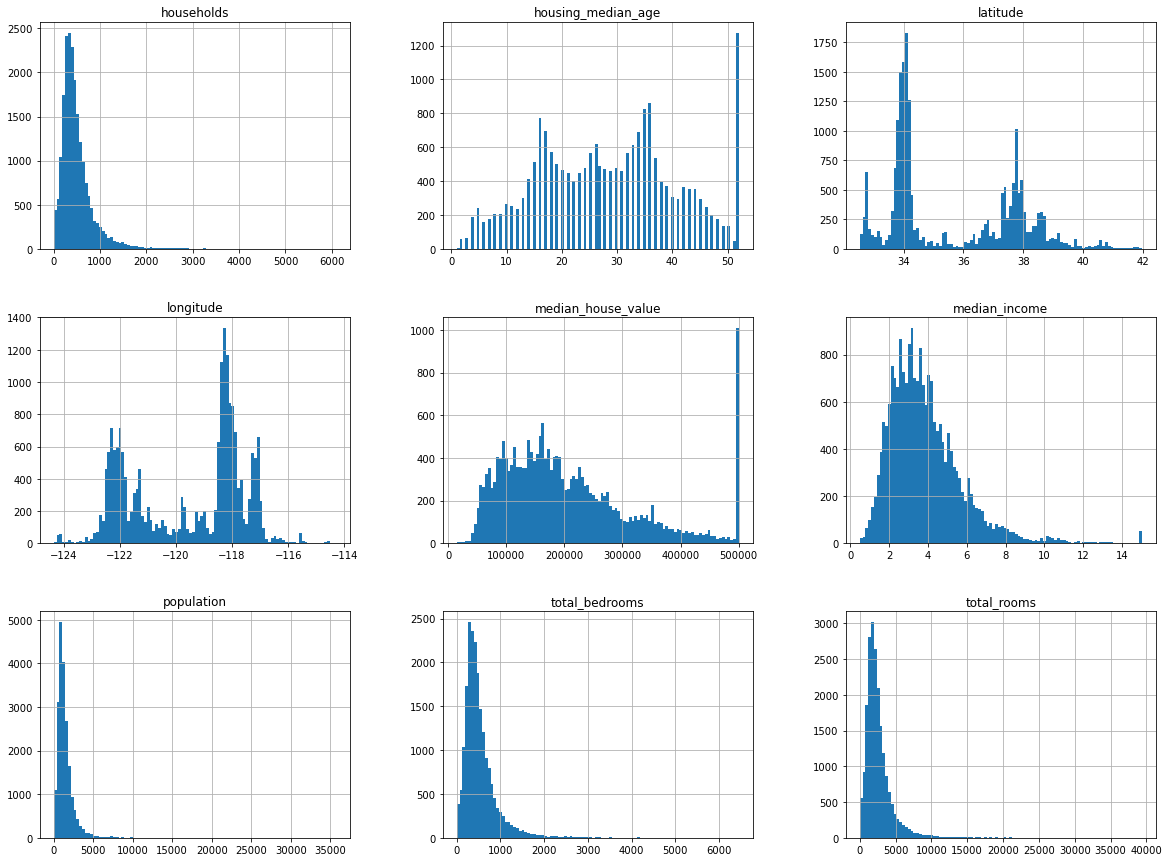

In [14]:
data.hist(bins=100, figsize=(20,15))

plt.show()

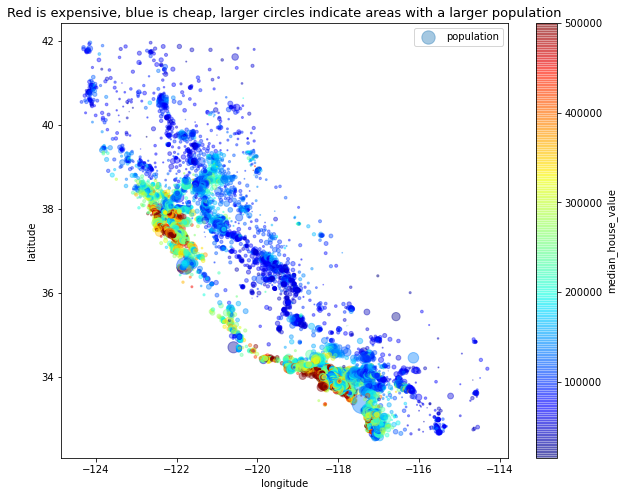

In [15]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(10,8),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Red is expensive, blue is cheap, larger circles indicate areas with a larger population',\
          fontweight = 20, fontsize = 13)
plt.legend()

In [16]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Data Cleaning and Preparation

In [17]:
#Fill in missing values with median

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [18]:
#Remove the text attribute because median can only be calculated on numerical attributes:
data_num=data.drop("ocean_proximity", axis=1)

In [19]:
imputer.fit(data_num)
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [20]:
X = imputer.transform(data_num)
data_num_clean = pd.DataFrame(X, columns=data_num.columns,index=data_num.index)
data_num_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [21]:
data_num_clean["rooms_per_household"] = data_num_clean["total_rooms"]/data_num_clean["households"]
data_num_clean["bedrooms_per_room"] = data_num_clean["total_bedrooms"]/data_num_clean["total_rooms"]
data_num_clean["population_per_household"]=data_num_clean["population"]/data_num_clean["households"]

In [22]:
#Preprocess the categorical input feature, `ocean_proximity`:
data_cat = data[["ocean_proximity"]]

In [23]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)

In [24]:
#ordinal_encoder.categories_

In [25]:
data_num_clean["ocean_proximity"]=data_cat_encoded
data_clean=data_num_clean
data_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,3.0


In [26]:
housing_labels = data_clean["median_house_value"]
data_clean = data_clean.drop("median_house_value", axis=1)
data_clean["median_house_value"] = housing_labels
data_clean

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556,3.0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842,3.0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260,3.0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945,3.0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467,3.0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,5.045455,0.224625,2.560606,1.0,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,6.114035,0.215208,3.122807,1.0,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,5.205543,0.215173,2.325635,1.0,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,5.329513,0.219892,2.123209,1.0,84700.0


In [27]:
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler()
X_scaled = minmax_scale.fit_transform(data_clean)
X_scaled.shape

(20640, 13)

In [28]:
#Splitting the dependent and independent variables

X = X_scaled[:,:-1]
y = X_scaled[:,-1]

print(X.shape)
print(y.shape)

(20640, 12)
(20640,)


In [29]:
#Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(16512, 12)
(16512,)
(4128, 12)


In [30]:
# Without Normalization of the data

train_data = train_data
test_data = test_data
train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

In [31]:
train_labels

array([[0.18144461],
       [0.75690616],
       [0.32494918],
       ...,
       [0.42701061],
       [0.55360803],
       [0.63917468]])

### 6 Layers Feedforward Neural Network

#### A function to create a list of mini-batches

In [32]:
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
    for i in range(n_minibatches): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini))
    return mini_batches 

In [33]:
mini_batches = create_mini_batches(train_data, train_labels, 16)
mini_batches_test = create_mini_batches(test_data, test_labels, 16)

In [34]:
nn = FNN([train_data.shape[1],50,100,200,100,5,1], 
         ['nothing', 'relu', 'relu', 'relu', 'relu', 'relu', 'nothing'], 
         0.0000000001)
nn.fit_minibatch(train_data, train_labels, test_data, test_labels, mini_batches, mini_batches_test, 140)

Epoch: 0. Training Loss: 4997.2452147829845. Test Loss: 4339.374415975466
Epoch: 1. Training Loss: 4477.582736402682. Test Loss: 3888.6898945165162
Epoch: 2. Training Loss: 4013.5537475544074. Test Loss: 3486.2324521321425
Epoch: 3. Training Loss: 3598.8887246927848. Test Loss: 3126.5668147745114
Epoch: 4. Training Loss: 3228.0849379204. Test Loss: 2804.9227795789557
Epoch: 5. Training Loss: 2896.3013711435215. Test Loss: 2517.1040077401635
Epoch: 6. Training Loss: 2599.2700857188925. Test Loss: 2259.4111019412358
Epoch: 7. Training Loss: 2333.2210992097457. Test Loss: 2028.5764224384893
Epoch: 8. Training Loss: 2094.818433128691. Test Loss: 1821.7086024551652
Epoch: 9. Training Loss: 1881.1054392064361. Test Loss: 1636.2451198857323
Epoch: 10. Training Loss: 1689.4578724458133. Test Loss: 1469.9115942897802
Epoch: 11. Training Loss: 1517.5434632383383. Test Loss: 1320.6867251250765
Epoch: 12. Training Loss: 1363.286966924037. Test Loss: 1186.7719837506122
Epoch: 13. Training Loss: 122